# Estimate a Linear Model for COVID-19 Growth in BC

Data from: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
site_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
data_dir = "csse_covid_19_data/csse_covid_19_time_series/"
filename = "time_series_19-covid-Confirmed.csv"

url = site_url + data_dir + filename
df = pd.read_csv(url, index_col=['Province/State', 'Country/Region'])

# Remove the Lat/Long data
lat_long = df[['Lat', 'Long']]
df = df.drop(['Lat', 'Long'], axis=1)

# Change remaining column labels to dates
df.columns = pd.to_datetime(df.columns)

# Swap index levels so country is first
df = df.swaplevel(0, 1)

df.shape

(468, 58)

In [3]:
df.head()

,,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19
Country/Region,Province/State,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,2,3,5,7,8,8,14,14,14,19,...,53,59,70,75,82,114,147,177,212,272
Japan,NaN,2,1,2,2,4,4,7,7,11,15,...,581,639,639,701,773,839,825,878,889,924
Singapore,NaN,0,1,3,3,4,5,7,7,10,13,...,160,178,178,200,212,226,243,266,313,345
Nepal,NaN,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Malaysia,NaN,0,0,0,3,4,4,4,7,8,8,...,129,149,149,197,238,428,566,673,790,900


## Select Data for One Country

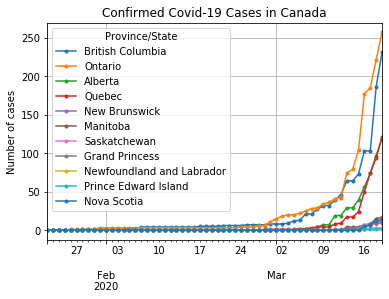

In [4]:
country = "Canada"
country_data = df.loc[country]
country_data.T.plot(style='.-')
plt.grid()
plt.ylabel("Number of cases")
plt.title(f"Confirmed Covid-19 Cases in {country}")
plt.show()

## Select Data for One Province/State

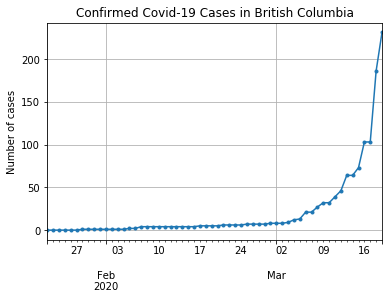

In [5]:
province = "British Columbia"
prov_data = df.loc[(country, province)]
prov_data.plot(style='.-')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.show()

## Approach 1 - Fit a linear model to the log of data

In [6]:
prov_data.head()

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
Name: (Canada, British Columbia), dtype: int64

In [140]:
# Choose start date for estimation data
start_date = '2020-03-01'
data = prov_data.loc[start_date:].values.reshape(-1, 1)
index = prov_data.loc[start_date:].index[1:]

# Prepare input and output data matrices
M = data[:-1]
y = data[1:]
n = len(y)
assert M.shape == (n, 1)
assert y.shape == (n, 1)
print(f"{n} data points")

18 data points


In [158]:
pd.DataFrame({
    'M': M.reshape(-1),
    'y': y.reshape(-1),
    'y/M': (y/M).reshape(-1)
}, index=index)

,M,y,y/M
2020-03-02,8,8,1.000000
2020-03-03,8,9,1.125000
2020-03-04,9,12,1.333333
2020-03-05,12,13,1.083333
2020-03-06,13,21,1.615385
2020-03-07,21,21,1.000000
2020-03-08,21,27,1.285714
2020-03-09,27,32,1.185185
2020-03-10,32,32,1.000000
2020-03-11,32,39,1.218750


In [214]:
# Compute parameter vector using least squares
# ('@' is matrix multiplication operator in Python > 3.4)
a = np.linalg.inv(M.T @ M) @ M.T @ y
a

array([[1.27765609]])

In [277]:
# This is a better fit for some reason
a[:] = 1.22

In [278]:
# Sum of residuals - should be close to zero
np.sum(M*a - y)

-33.58000000000003

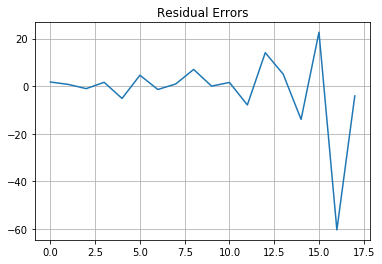

In [279]:
plt.plot(M*a - y)
plt.title('Residual Errors')
plt.grid()

In [280]:
# MSE
0.5*np.sum((M*a - y)**2)

2380.7626000000005

In [292]:
# Choose prediction horizon
end_date = '2020-03-31'
n_pred = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

# Make predictions with model
x = np.zeros((1, n_pred + 1))
x[:, 0] = M[0] - 2.65
for k in range(1, n_pred + 1):
    x[:, k] = a*x[:, k-1]

pred_index = pd.Index(pd.date_range(start_date, end_date))
predictions = pd.Series(x.reshape(-1,), index=pred_index)

# MSE of predictions (they are very sensitive to initial x)
np.sum((x[:, 1:19].T - M*a)**2)

2839.9350990053636

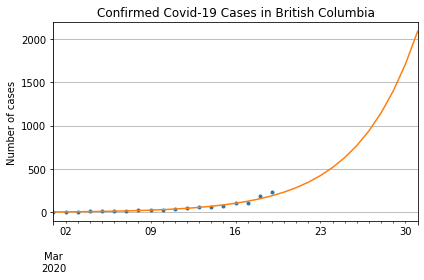

In [293]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc.png')
plt.show()

In [294]:
predictions.tail()

2020-03-27     941.259515
2020-03-28    1148.336609
2020-03-29    1400.970663
2020-03-30    1709.184208
2020-03-31    2085.204734
Freq: D, dtype: float64

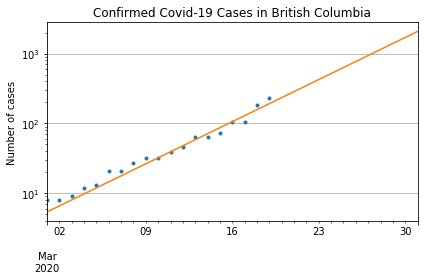

In [295]:
prov_data.loc[start_date:].plot(style='.', label='observed data')
predictions.plot(style='-', label='prediction')
plt.ylabel("Number of cases")
plt.yscale('log')
plt.grid()
plt.title(f"Confirmed Covid-19 Cases in {province}")
plt.tight_layout()
plt.savefig('covid_growth_bc_log.png')
plt.show()